# import

In [1]:
import sys
sys.path.append('../')
from setting import *

In [12]:
IS_SCORING =True

# 入出力

In [9]:
df_result = pd.read_csv(FILE_RESULT_INTER)
print(df_result.shape)
df_result.head(1)

(387828, 28)


,着順,枠番,馬番,馬名,性齢,斤量,騎手,タイム,着差,通過,上り,単勝,人気,馬体重,調教師,馬主,賞金(万円),race_id,gender,age,weight,weight_change,abs_weight_change,passing1,passing2,passing3,passing4,place
0,1,3,3,マイネルギブソン,牡2,54.0,丹内祐次,1:52.1,NaN,1-1-1-1,34.7,6.0,5.0,432(+10),[東] 萱野浩二,サラブレッドクラブ・ラフィアン,1623.1,201001020110,牡,2,432.0,10.0,10.0,1.0,1.0,1.0,1.0,東


In [10]:
df_result.馬名.nunique()

46107

In [11]:
df_info = pd.read_csv(FILE_INFO_INTER)
print(df_info.shape)
df_info.head(1)

(27125, 13)


,race_id,race_date,race_title,race_class,course_name,course_type,course_direction,course_distance,condition,whether,condition_int,whether_int,race_class_prize
0,201001020110,2010-09-11,コスモス賞,2歳オープン,札幌,芝,右,1800,良,曇,1,2,オープン


In [7]:
drop_cols = [
    '枠番',
    '性齢',
    '着差',
    '単勝',
    '馬体重',
    '人気',
    '馬主',
    'passing1',
    'passing2',
    'passing3',
    'passing4',
    'weight_change',
    'abs_weight_change',
]

df_result.drop(drop_cols, axis=1, inplace=True)

In [ ]:
if IS_SCOREING:
    df_main = pd.read_csv(FILE_INPUT_HOURSE)
    print(df_main.shape)
    display(df_main.head(2))
    TARGET_ID = set(df_main.race_id.unique())
    print('対象レース数: ', len(TARGET_ID))
    df_result = df_result.loc[df_result.馬名.isin({df_main.馬名})]
    print(df_result.shape)
    display(df_result.head(2))
    df_info_tmp = pd.read_csv(FILE_INPUT_INFO)
    print(df_info_tmp.shape)
    display(df_info_tmp.head(2))
    df_info = pd.concat([df_info, df_info_tmp], ignore_index=True)

In [8]:
drop_cols = [
    'race_title',
    'race_class',
#     'condition_int',
#     'whether',
#     'whether_int'
]
df_info.drop(drop_cols, axis=1, inplace=True)

# merge

In [9]:
df_info.race_date = pd.to_datetime(df_info.race_date)
df_info['race_month'] = df_info.race_date.dt.month

df_result = df_result.merge(df_info, how='left', on='race_id')
df_result.shape

(387828, 26)

In [10]:
df_result.sort_values('race_date', inplace=True)

# 加工

カラム名|内容|済
---|---|---
arrival|レースの実際の結果|1
start_number|馬番|1
arrival_mean_total|過去の着順平均|1
arrival_mean_upper|過去の着順平均（新馬・未勝利除く）|1
gender|性別|1
age|年齢|1
speed_mean|過去の平均秒速
last_passing_n_arrival_diff_mean|最終コーナー順位と着順の差の平均
last_speed_mean|上り平均秒速
body_weight_mean|馬体重平均
add_weight_per|斤量の体重に対する割合
total_prize|過去の賞金合計
race_month|レースが行われた月|1
newhourse_race_times|新馬/未勝利の出走回数
course_type_result|arrival_mean_totalに対する、<br>コースタイプが同じ時の着順平均の割合
course_direction_result|arrival_mean_totalに対する、<br>コースの向きが同じ時の着順平均の割合
course_distance|前回レースとの距離の差
condition_result|arrival_mean_totalに対する、<br>馬場状態が同じ時の着順平均の割合
jockey_arrival_mean|騎手の平均着順
trainer_arrival_mean|調教師の平均着順
trainer_place|調教師の拠点的な|1
course_cluster_result|arrival_mean_totalに対する、<br>コースクラスタが同じ時の着順平均の割合

- 人気に対する差

In [11]:
df_result.rename(columns={'着順':'arrival'}, inplace=True)

In [12]:
# データ中初登場フラグ
df_result.sort_values('race_date', inplace=True)
df_result['first_data_flg'] = 0
df_result.loc[df_result.groupby('馬名').head(1).index, 'first_data_flg'] = 1
df_result.first_data_flg.value_counts()

0    341721
1     46107
Name: first_data_flg, dtype: int64

In [13]:
df_result.head(2)

,arrival,馬番,馬名,斤量,騎手,タイム,通過,上り,調教師,賞金(万円),race_id,gender,age,weight,place,race_date,course_name,course_type,course_direction,course_distance,condition,whether,condition_int,whether_int,race_class_prize,race_month,first_data_flg
1859,4,13,エーシンダードマン,53.0,池添謙一,3:07.2,6-6-5-3,37.2,[西] 大久保龍,350.0,201008010110,牡,6,510.0,西,2010-01-05,京都,芝,右,3000,良,晴,1,1,オープン,1,1
889,12,8,ワーキングウーマン,55.0,田中勝春,1:12.4,13-13,37.7,[西] 須貝尚介,NaN,201006010110,牝,6,456.0,西,2010-01-05,中山,ダ,右,1200,良,晴,1,1,3勝クラス,1,1


## weight

In [14]:
# weight3項間移動平均
df_result.sort_values('race_date', inplace=True)

v_list = []
for k,v in tqdm.tqdm(df_result.groupby('馬名')):
    v['weight_3_mean'] = v.weight.rolling(window=3).mean()
    v['pre_weight_3_mean'] = v['weight_3_mean'].shift(1)
    v_list.append(v)

df_result = pd.concat(v_list, ignore_index=True)
df_result.shape

100%|███████████████████████████████████████████████████████████████████████████| 46107/46107 [01:45<00:00, 437.25it/s]


(387828, 29)

In [15]:
# weight欠損埋める
df_result['weight_null_flg'] = 0
df_result.loc[df_result.weight.isnull(), 'weight_null_flg'] = 1

df_result.weight = df_result.weight.fillna(df_result.pre_weight_3_mean)

In [16]:
df_result.loc[df_result.weight_null_flg==1]

,arrival,馬番,馬名,斤量,騎手,タイム,通過,上り,調教師,賞金(万円),race_id,gender,age,weight,place,race_date,course_name,course_type,course_direction,course_distance,condition,whether,condition_int,whether_int,race_class_prize,race_month,first_data_flg,weight_3_mean,pre_weight_3_mean,weight_null_flg
49142,12,5,エンマダイオウ,56.0,幸英明,NaN,NaN,NaN,NaN,NaN,201808020605,牡,3,NaN,NaN,2018-02-11,京都,芝,右,1600,重,曇,3,2,未勝利,2,0,NaN,NaN,1
108789,10,14,コートシャルマン,55.0,横山和生,1:35.3,NaN,NaN,NaN,NaN,201806010112,牝,6,464.0,NaN,2018-01-06,中山,芝,右,1600,良,晴,1,1,2勝クラス,1,0,NaN,464.0,1
120611,8,2,サビーナクレスタ,54.0,北村宏司,1:24.5,12-12,35.6,[東] 大竹正博,NaN,201305030305,牡,2,NaN,東,2013-06-08,東京,芝,左,1400,良,晴,1,1,新馬,6,1,NaN,NaN,1
335051,10,5,メタルカラー,54.0,藤岡康太,1:28.1,14-16,38.8,NaN,NaN,201808020603,牝,3,450.0,NaN,2018-02-11,京都,ダ,右,1400,不良,晴,4,1,未勝利,2,0,NaN,450.0,1
372184,13,12,レンジストライク,56.0,バルジュ,1:53.8,NaN,NaN,NaN,NaN,201808020604,牡,3,NaN,NaN,2018-02-11,京都,ダ,右,1800,不良,曇,4,2,1勝クラス,2,0,NaN,NaN,1


In [18]:
df_result['weight_change_rate'] = df_result.weight / df_result.pre_weight_3_mean

In [20]:
df_result.rename(columns={'斤量':'handy_weight'}, inplace=True)
df_result['handy_rate'] = df_result.handy_weight / df_result.weight

<AxesSubplot:>

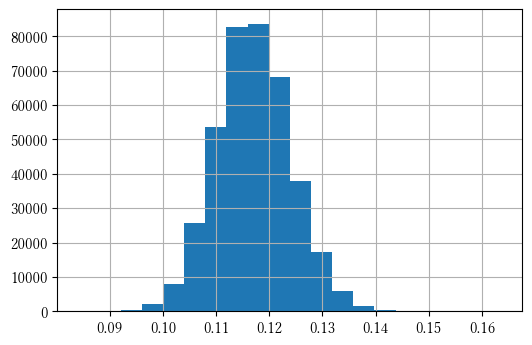

In [22]:
df_result.handy_rate.hist(bins=20)

## 前回の情報（中央競馬のみ）

### 前回のレースからの日数

In [23]:
df_result.sort_values('race_date', ascending=True, inplace=True)
df_result['last_race_date'] = df_result.groupby('馬名').race_date.shift(1)

In [24]:
df_result['interval_days'] = (df_result.race_date - df_result.last_race_date).dt.days

<AxesSubplot:>

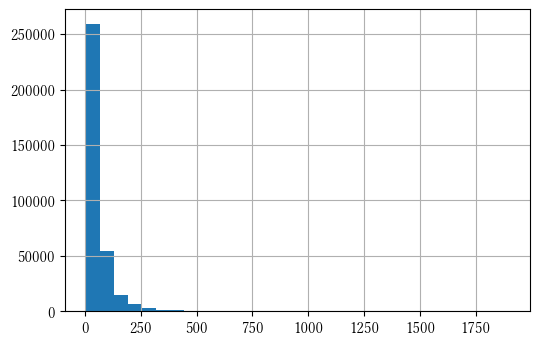

In [25]:
df_result.interval_days.hist(bins=30)

In [26]:
df_result.sort_values('interval_days', ascending=False).head()

,arrival,馬番,馬名,handy_weight,騎手,タイム,通過,上り,調教師,賞金(万円),race_id,gender,age,weight,place,race_date,course_name,course_type,course_direction,course_distance,condition,whether,condition_int,whether_int,race_class_prize,race_month,first_data_flg,weight_3_mean,pre_weight_3_mean,weight_null_flg,weight_change_rate,handy_rate,last_race_date,interval_days
386349,15,5,ヴィーヴァギブソン,54.0,三津谷隼,1:27.7,15-15,38.1,[西] 作田誠二,NaN,201808020112,セ,11,532.0,西,2018-01-27,京都,ダ,右,1400,稍重,曇,2,2,2勝クラス,1,0,526.000000,522.000000,0,1.019157,0.101504,2012-11-18,1896.0
79089,11,7,キープトライン,57.0,原田和真,2:02.2,10-10-11-11,37.7,[東] 粕谷昌央,NaN,201810010309,牡,8,502.0,東,2018-02-17,小倉,芝,右,2000,良,晴,1,1,1勝クラス,2,0,484.000000,476.666667,0,1.053147,0.113546,2013-03-24,1791.0
248428,10,10,バアゼルリバー,57.0,松山弘平,2:14.2,9-10-10-11,34.2,[西] 松田博資,NaN,201408050310,牡,8,508.0,西,2014-11-15,京都,芝,右,2200,良,晴,1,1,3勝クラス,11,0,NaN,NaN,0,NaN,0.112205,2010-02-14,1735.0
52301,1,6,オジュウチョウサン,57.0,武豊,2:42.3,4-3-2-1,37.1,[東] 和田正一,1076.6,201803020309,牡,7,510.0,東,2018-07-07,福島,芝,右,2600,稍重,曇,2,2,1勝クラス,7,0,495.333333,NaN,0,NaN,0.111765,2013-11-16,1694.0
37333,10,6,ウルトラカイザー,56.0,井上俊彦,1:44.4,6-5-8-8,38.0,[地] 林和弘,NaN,201501010611,牡,7,484.0,地,2015-08-16,札幌,ダ,右,1700,稍重,曇,2,2,G3,8,0,463.333333,NaN,0,NaN,0.115702,2011-01-30,1659.0


### 前回のレースは芝/ダート

In [27]:
df_result.sort_values('race_date')

,arrival,馬番,馬名,handy_weight,騎手,タイム,通過,上り,調教師,賞金(万円),race_id,gender,age,weight,place,race_date,course_name,course_type,course_direction,course_distance,condition,whether,condition_int,whether_int,race_class_prize,race_month,first_data_flg,weight_3_mean,pre_weight_3_mean,weight_null_flg,weight_change_rate,handy_rate,last_race_date,interval_days
129783,5,10,シェーンヴァルト,55.0,北村友一,2:00.8,15-14-2-2,36.0,[西] 岡田稲男,430.0,201006010111,牡,4,476.0,西,2010-01-05,中山,芝,右,2000,良,晴,1,1,G3,1,1,NaN,NaN,0,NaN,0.115546,NaT,NaN
282290,15,3,ブルーマーテル,52.0,田中博康,2:02.0,5-5-8-8,36.6,[東] 菅原泰夫,NaN,201006010111,牡,6,466.0,東,2010-01-05,中山,芝,右,2000,良,晴,1,1,G3,1,1,NaN,NaN,0,NaN,0.111588,NaT,NaN
383304,16,11,ワンモアチャッター,52.0,小林淳一,2:05.0,16-16-16-16,38.1,[東] 佐藤吉勝,NaN,201006010111,牡,10,462.0,東,2010-01-05,中山,芝,右,2000,良,晴,1,1,G3,1,1,NaN,NaN,0,NaN,0.112554,NaT,NaN
142403,15,4,シルクプラチナム,57.0,大野拓弥,1:13.0,8-8,38.8,[東] 尾形充弘,NaN,201006010110,牡,7,534.0,東,2010-01-05,中山,ダ,右,1200,良,晴,1,1,3勝クラス,1,1,NaN,NaN,0,NaN,0.106742,NaT,NaN
121772,5,11,サラトガ,55.0,木幡初広,1:11.4,4-4,37.5,[東] 本郷一彦,178.0,201006010110,牝,6,502.0,東,2010-01-05,中山,ダ,右,1200,良,晴,1,1,3勝クラス,1,1,NaN,NaN,0,NaN,0.109562,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224472,15,18,ドミナシオン,55.0,Ｍ．デム,2:07.5,10-10-9-10,39.6,[西] 藤岡健一,NaN,201906050905,牡,2,492.0,西,2019-12-28,中山,芝,右,2000,良,晴,1,1,新馬,12,1,NaN,NaN,0,NaN,0.111789,NaT,NaN
147737,12,7,ジャジャウマ,52.0,木幡育也,2:00.8,12-13-14-14,42.2,[東] 深山雅史,NaN,201906050902,牝,2,408.0,東,2019-12-28,中山,ダ,右,1800,良,晴,1,1,未勝利,12,0,416.000000,NaN,0,NaN,0.127451,2019-10-05,84.0
41294,7,8,エクスプレッサー,55.0,石橋脩,1:51.2,3-3-3-3,38.5,[東] 堀宣行,NaN,201906050904,牡,2,488.0,東,2019-12-28,中山,芝,右,1800,良,晴,1,1,未勝利,12,0,NaN,NaN,0,NaN,0.112705,2019-12-01,27.0
106704,1,13,コパノライダー,53.0,斎藤新,1:12.6,2-2,38.1,[東] 斎藤誠,500.0,201906050903,牡,2,450.0,東,2019-12-28,中山,ダ,右,1200,良,晴,1,1,未勝利,12,0,450.666667,452.666667,0,0.994109,0.117778,2019-12-14,14.0


In [28]:
df_result.course_type.value_counts()

ダ    194303
芝    193525
Name: course_type, dtype: int64

In [29]:
df_result.sort_values('race_date', inplace=True)
df_result['last_turf_flg'] = df_result.sort_values('race_date').groupby('馬名').course_type.shift(1)
df_result.last_turf_flg = df_result.last_turf_flg.fillna(0).replace({'芝':1, 'ダ':0})
df_result.last_turf_flg.value_counts()

0    213998
1    173830
Name: last_turf_flg, dtype: int64

In [30]:
# 今回芝、前回ダートの子
df_result.loc[(df_result.course_type=='芝') & (df_result.last_turf_flg==0) & (df_result.first_data_flg==0)]

,arrival,馬番,馬名,handy_weight,騎手,タイム,通過,上り,調教師,賞金(万円),race_id,gender,age,weight,place,race_date,course_name,course_type,course_direction,course_distance,condition,whether,condition_int,whether_int,race_class_prize,race_month,first_data_flg,weight_3_mean,pre_weight_3_mean,weight_null_flg,weight_change_rate,handy_rate,last_race_date,interval_days,last_turf_flg
324240,16,15,ムーンテンダー,56.0,国分恭介,1:38.4,9-8,37.8,[西] 飯田雄三,NaN,201009010111,牡,3,476.0,西,2010-02-27,阪神,芝,右,1600,良,晴,1,1,G3,2,0,NaN,NaN,0,NaN,0.117647,2010-01-31,27.0,0
342771,9,6,ヤマニンフリスキー,56.0,国分恭介,2:03.4,10-12-12-12,36.1,[西] 野村彰彦,NaN,201007020710,牡,3,448.0,西,2010-03-27,中京,芝,左,2000,良,晴,1,1,1勝クラス,3,0,NaN,NaN,0,NaN,0.125000,2010-03-14,13.0,0
33218,4,14,ウインブシドウ,56.0,北村友一,2:02.8,2-2-2-3,36.1,[西] 池江泰郎,150.0,201007020710,牡,3,490.0,西,2010-03-27,中京,芝,左,2000,良,晴,1,1,1勝クラス,3,0,NaN,NaN,0,NaN,0.114286,2010-03-14,13.0,0
152084,4,7,ジョーメテオ,57.0,池添謙一,1:35.6,1-1,35.1,[西] 柴田光陽,220.0,201009020111,牡,4,504.0,西,2010-03-27,阪神,芝,右,1600,良,晴,1,1,2勝クラス,3,0,507.333333,NaN,0,NaN,0.113095,2010-03-13,14.0,0
311036,18,6,マチカネハヤテ,52.0,熊沢重文,1:08.9,3-3,35.7,[西] 河内洋,NaN,201008030110,牝,5,456.0,西,2010-04-24,京都,芝,右,1200,良,晴,1,1,オープン,4,0,NaN,NaN,0,NaN,0.114035,2010-01-05,109.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163656,14,3,スペロラルーチェ,54.0,山田敬士,2:06.5,9-11-14-14,37.4,[東] 中野栄治,NaN,201906050907,牝,3,440.0,東,2019-12-28,中山,芝,右,2000,良,晴,1,1,1勝クラス,12,0,442.000000,443.333333,0,0.992481,0.122727,2019-12-08,20.0,0
27456,8,6,イルルーメ,57.0,石堂響,2:05.1,12-13-10-9,36.6,[東] 高市圭二,NaN,201906050907,牡,4,508.0,東,2019-12-28,中山,芝,右,2000,良,晴,1,1,1勝クラス,12,0,496.666667,488.666667,0,1.039563,0.112205,2019-12-07,21.0,0
238486,18,13,ネルソンタッチ,56.0,高倉稜,1:37.2,7-11,35.0,[西] 牧浦充徳,NaN,201909050908,牡,3,490.0,西,2019-12-28,阪神,芝,右,1600,良,晴,1,1,1勝クラス,12,0,484.666667,482.666667,0,1.015193,0.114286,2019-12-15,13.0,0
196118,12,15,チューダーローズ,54.0,小牧太,1:36.7,18-18,34.0,[西] 服部利之,NaN,201909050908,牝,3,480.0,西,2019-12-28,阪神,芝,右,1600,良,晴,1,1,1勝クラス,12,0,478.000000,478.000000,0,1.004184,0.112500,2019-09-01,118.0,0


### 前回と今回の距離の差

In [31]:
df_result.sort_values('race_date', inplace=True)
df_result['distance_diff'] = df_result.groupby('馬名').course_distance.diff()

<AxesSubplot:>

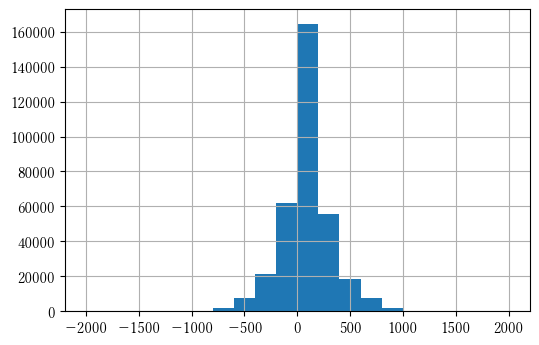

In [32]:
df_result.distance_diff.hist(bins=20)

### ※以下、芝のみ

In [33]:
# ダート削除
df_result = df_result.query('course_type=="芝"')

### 前回の芝の天気とコンディション

In [34]:
df_result.sort_values('race_date', inplace=True)
df_result['last_wheter'] = df_result.groupby('馬名').whether_int.shift(1)
df_result['last_condition'] = df_result.groupby('馬名').condition_int.shift(1)

### 前回のレースの着順

In [35]:
df_result.race_class_prize.value_counts()

未勝利      60766
1勝クラス    53492
2勝クラス    25239
新馬       21081
3勝クラス    11089
オープン      7985
G3        7081
G2        3999
G1        2793
Name: race_class_prize, dtype: int64

In [36]:
# 前回とクラスが異なるか否か
df_result.sort_values('race_date', inplace=True)
df_result['last_class_prize'] = df_result.groupby('馬名').race_class_prize.shift(1)
df_result['is_first_in_prize'] = 0
df_result.loc[(df_result.race_class_prize != df_result.last_class_prize), 'is_first_in_prize'] = 1
df_result.is_first_in_prize.value_counts()

0    110583
1     82942
Name: is_first_in_prize, dtype: int64

In [37]:
df_result['last_arrival'] = df_result.groupby('馬名').arrival.shift()

In [38]:
# 前回とクラスが変わったときの、前回の着順と今回の着順のクロス集計
pd.crosstab(
    df_result.query('is_first_in_prize==1').arrival,
    df_result.query('is_first_in_prize==1').last_arrival
).style.background_gradient()

last_arrival,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
arrival,,,,,,,,,,,,,,,,,,
1,1466,519,394,294,236,218,132,137,118,98,63,57,42,47,45,19,14,9
2,1313,430,357,257,223,189,173,149,130,102,69,75,45,38,29,31,5,7
3,1192,322,304,315,251,214,177,146,136,120,91,79,64,38,34,37,10,9
4,1109,277,294,261,267,216,175,157,140,138,110,75,60,59,53,41,10,11
5,1030,249,244,228,249,238,214,188,191,112,133,93,70,54,43,34,12,12
6,990,223,225,236,226,254,226,227,168,152,129,118,80,65,54,38,21,15
7,894,180,191,206,217,225,223,224,204,162,134,123,90,77,61,34,20,16
8,816,169,153,185,212,215,218,209,190,187,153,121,110,93,58,47,21,14
9,722,113,193,182,187,211,231,207,220,182,156,136,121,101,89,44,30,18


In [39]:
# 前回が1位だったときいの、今回の着順とクラスのクロス集計
pd.crosstab(
    df_result.query('(is_first_in_prize==1) and (last_arrival==1)').arrival,
    df_result.query('(is_first_in_prize==1) and (last_arrival==1)').race_class_prize,
).style.background_gradient()

race_class_prize,1勝クラス,2勝クラス,3勝クラス,G1,G2,G3,オープン
arrival,,,,,,,
1,388,373,206,51,110,155,183
2,354,331,186,50,92,140,160
3,345,291,162,51,70,134,139
4,327,250,134,47,72,132,147
5,312,225,138,42,61,124,128
6,305,230,114,45,61,118,117
7,276,197,104,45,65,108,99
8,233,187,69,41,74,121,91
9,197,159,93,44,57,95,77


In [40]:
# 前回とクラスが同じときの、前回の着順と今回の着順のクロス集計
pd.crosstab(
    df_result.query('is_first_in_prize==0').arrival,
    df_result.query('is_first_in_prize==0').last_arrival
).style.background_gradient()

last_arrival,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
arrival,,,,,,,,,,,,,,,,,,
1,140,1933,1297,1025,715,626,482,361,300,232,166,140,96,97,55,41,13,9
2,86,1506,1302,1009,905,679,581,462,379,252,246,205,139,89,81,54,29,10
3,104,1254,1168,1017,896,741,598,540,392,354,292,213,160,130,96,61,27,17
4,71,1027,1052,969,876,793,685,554,494,421,308,242,191,141,107,80,33,19
5,61,847,927,974,868,744,732,624,527,473,367,281,217,188,135,86,27,30
6,48,683,798,848,909,781,719,646,563,486,395,338,265,198,151,107,59,18
7,31,621,662,783,810,755,763,699,624,561,465,401,310,218,172,99,55,21
8,36,534,638,665,739,718,734,723,639,549,500,406,352,260,195,160,55,32
9,43,436,497,636,663,689,669,676,604,558,512,424,376,310,237,152,67,58


In [41]:
# 前回とクラスに関わらず、前回の着順と今回の着順のクロス集計
pd.crosstab(df_result.arrival, df_result.last_arrival).style.background_gradient()

last_arrival,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
arrival,,,,,,,,,,,,,,,,,,
1,1606,2452,1691,1319,951,844,614,498,418,330,229,197,138,144,100,60,27,18
2,1399,1936,1659,1266,1128,868,754,611,509,354,315,280,184,127,110,85,34,17
3,1296,1576,1472,1332,1147,955,775,686,528,474,383,292,224,168,130,98,37,26
4,1180,1304,1346,1230,1143,1009,860,711,634,559,418,317,251,200,160,121,43,30
5,1091,1096,1171,1202,1117,982,946,812,718,585,500,374,287,242,178,120,39,42
6,1038,906,1023,1084,1135,1035,945,873,731,638,524,456,345,263,205,145,80,33
7,925,801,853,989,1027,980,986,923,828,723,599,524,400,295,233,133,75,37
8,852,703,791,850,951,933,952,932,829,736,653,527,462,353,253,207,76,46
9,765,549,690,818,850,900,900,883,824,740,668,560,497,411,326,196,97,76


In [42]:
# 前回とクラスが同じ、前回ダート、今回芝
pd.crosstab(
    df_result.query('(is_first_in_prize==0) and (last_turf_flg==0) and (first_data_flg==0) and (course_type=="芝")').arrival,
    df_result.query('(is_first_in_prize==0) and (last_turf_flg==0) and (first_data_flg==0) and (course_type=="芝")').last_arrival
).style.background_gradient()

last_arrival,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
arrival,,,,,,,,,,,,,,,,,,
1,1,16,13,20,21,25,30,21,19,27,19,16,7,10,12,8,1,1
2,0,8,12,27,23,39,38,31,28,14,20,15,12,7,5,6,3,1
3,2,10,18,19,21,51,35,38,19,29,26,15,24,11,9,5,6,3
4,2,8,24,27,18,47,32,42,33,35,28,25,19,17,10,10,7,6
5,0,7,10,22,21,35,52,51,34,36,31,34,23,33,20,13,4,3
6,1,8,8,21,26,43,50,47,49,53,26,25,28,24,20,13,8,4
7,0,3,9,18,21,46,48,52,45,60,50,47,28,28,25,22,11,5
8,0,5,11,16,14,35,47,38,67,54,60,45,49,37,23,20,5,3
9,2,4,10,11,15,43,46,52,52,57,49,38,31,52,36,23,13,8


In [43]:
# 前回とクラスが違う、前回ダート、今回芝
pd.crosstab(
    df_result.query('(is_first_in_prize==1) and (last_turf_flg==0) and (first_data_flg==0) and (course_type=="芝")').arrival,
    df_result.query('(is_first_in_prize==1) and (last_turf_flg==0) and (first_data_flg==0) and (course_type=="芝")').last_arrival
).style.background_gradient()

last_arrival,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
arrival,,,,,,,,,,,,,,,,,,
1,3,8,9,7,16,17,11,17,13,13,7,2,3,4,7,1,1,2
2,3,12,9,7,11,12,8,18,9,14,9,10,4,5,0,6,0,0
3,3,11,11,15,14,26,12,14,17,11,12,9,8,5,3,5,1,3
4,6,11,15,17,21,21,23,13,13,17,14,14,6,6,11,1,0,2
5,5,5,12,8,13,24,27,25,29,15,16,16,8,8,8,4,1,1
6,5,7,10,14,12,20,19,32,27,22,21,19,17,7,12,7,3,1
7,6,12,12,18,21,33,36,23,40,28,21,19,12,12,9,8,2,3
8,7,15,9,12,23,30,20,24,29,32,20,14,27,15,10,15,2,3
9,2,7,10,12,25,29,45,32,44,32,29,29,21,19,15,10,4,5


In [44]:
# 同じクラスの芝での、2回前と3回前の着順
df_result.sort_values('race_date', inplace=True)

df_result['p2_arrival'] = df_result.groupby(['馬名', 'race_class_prize']).arrival.shift(2)
df_result['p3_arrival'] = df_result.groupby(['馬名', 'race_class_prize']).arrival.shift(3)

In [45]:
pd.crosstab(
    df_result.query('is_first_in_prize==0').arrival,
    df_result.query('is_first_in_prize==0').p2_arrival
).style.background_gradient()

p2_arrival,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
arrival,,,,,,,,,,,,,,,,,,
1,210,1181,939,776,609,469,371,316,242,193,148,116,89,66,55,38,15,12
2,196,973,914,763,678,532,423,371,339,267,213,153,128,97,67,37,17,12
3,172,820,855,666,644,587,495,447,371,295,233,182,156,123,79,57,24,16
4,144,750,745,725,696,601,580,442,357,302,253,200,162,128,86,52,18,16
5,122,658,661,697,677,625,553,446,456,336,290,215,174,145,99,59,28,26
6,126,534,633,669,608,591,560,505,418,358,340,243,186,144,131,76,28,15
7,112,468,546,566,615,588,598,560,443,391,343,296,227,173,132,88,46,15
8,123,423,493,528,584,552,591,545,418,417,359,322,238,177,134,101,36,38
9,82,365,421,445,531,501,544,512,461,419,331,326,281,219,157,123,47,25


In [46]:
pd.crosstab(
    df_result.query('is_first_in_prize==0').arrival,
    df_result.query('is_first_in_prize==0').p3_arrival
).style.background_gradient()

p3_arrival,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
arrival,,,,,,,,,,,,,,,,,,
1,170,771,655,511,481,403,335,260,214,159,131,107,83,63,40,31,17,9
2,128,712,657,567,518,456,343,315,259,217,156,128,112,70,70,34,15,9
3,149,622,636,586,503,425,407,307,280,247,177,150,122,99,65,39,12,12
4,112,532,578,587,533,474,398,354,282,273,216,165,131,125,74,42,21,13
5,112,468,556,516,543,470,449,370,339,281,236,189,139,105,74,62,26,12
6,119,460,466,472,533,458,425,404,295,294,248,188,153,131,76,60,23,15
7,98,384,426,485,484,463,427,434,328,308,294,243,190,125,82,73,27,21
8,76,367,392,473,427,469,469,440,350,316,261,205,180,115,106,71,35,17
9,83,305,382,401,404,413,398,410,333,304,246,201,181,147,103,66,34,24


### 前回のスピード

In [47]:
df_result

,arrival,馬番,馬名,handy_weight,騎手,タイム,通過,上り,調教師,賞金(万円),race_id,gender,age,weight,place,race_date,course_name,course_type,course_direction,course_distance,condition,whether,condition_int,whether_int,race_class_prize,race_month,first_data_flg,weight_3_mean,pre_weight_3_mean,weight_null_flg,weight_change_rate,handy_rate,last_race_date,interval_days,last_turf_flg,distance_diff,last_wheter,last_condition,last_class_prize,is_first_in_prize,last_arrival,p2_arrival,p3_arrival
129783,5,10,シェーンヴァルト,55.0,北村友一,2:00.8,15-14-2-2,36.0,[西] 岡田稲男,430.0,201006010111,牡,4,476.0,西,2010-01-05,中山,芝,右,2000,良,晴,1,1,G3,1,1,NaN,NaN,0,NaN,0.115546,NaT,NaN,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
82714,11,3,クラウンプリンセス,54.0,太宰啓介,1:34.7,7-6,35.6,[西] 橋口弘次,NaN,201008010111,牝,6,488.0,西,2010-01-05,京都,芝,右,1600,良,晴,1,1,G3,1,1,NaN,NaN,0,NaN,0.110656,NaT,NaN,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
383304,16,11,ワンモアチャッター,52.0,小林淳一,2:05.0,16-16-16-16,38.1,[東] 佐藤吉勝,NaN,201006010111,牡,10,462.0,東,2010-01-05,中山,芝,右,2000,良,晴,1,1,G3,1,1,NaN,NaN,0,NaN,0.112554,NaT,NaN,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
7209,9,13,アスクデピュティ,50.0,武士沢友,2:01.2,13-13-13-13,35.1,[東] 伊藤正徳,NaN,201006010111,牝,6,486.0,東,2010-01-05,中山,芝,右,2000,良,晴,1,1,G3,1,1,NaN,NaN,0,NaN,0.102881,NaT,NaN,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
269453,10,16,フィールドベアー,57.0,秋山真一,1:34.7,4-3,35.8,[西] 野村彰彦,NaN,201008010111,牡,7,494.0,西,2010-01-05,京都,芝,右,1600,良,晴,1,1,G3,1,1,NaN,NaN,0,NaN,0.115385,NaT,NaN,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157529,11,4,スターオブグリーン,55.0,岩橋勇二,1:50.3,8-9,35.9,[地] 池田忠好,NaN,201909050906,牡,2,440.0,地,2019-12-28,阪神,芝,右,1800,良,晴,1,1,1勝クラス,12,0,NaN,NaN,0,NaN,0.125000,2019-08-10,140.0,1,0.0,2.0,2.0,オープン,1,8.0,NaN,NaN
140084,3,6,ショウナンタイガ,56.0,柴山雄一,1:10.0,4-4,34.4,[西] 池添兼雄,464.8,201909050912,牡,3,480.0,西,2019-12-28,阪神,芝,右,1200,良,曇,1,2,3勝クラス,12,0,472.0,470.666667,0,1.019830,0.116667,2019-09-28,91.0,1,0.0,1.0,1.0,3勝クラス,0,5.0,NaN,NaN
8190,16,5,アズマエピカリス,55.0,藤岡康太,1:49.5,7-8,37.4,[西] 河内洋,NaN,201909050903,牡,2,530.0,西,2019-12-28,阪神,芝,右,1800,良,晴,1,1,未勝利,12,0,526.0,NaN,0,NaN,0.103774,2019-12-07,21.0,1,0.0,2.0,1.0,未勝利,0,3.0,NaN,NaN
227723,5,2,ナイトバナレット,57.0,坂井瑠星,1:36.2,13-16-16,34.5,[西] 矢作芳人,150.0,201906050912,牡,5,488.0,西,2019-12-28,中山,芝,右,1600,良,晴,1,1,2勝クラス,12,0,486.0,482.000000,0,1.012448,0.116803,2019-11-03,55.0,1,200.0,2.0,1.0,2勝クラス,0,7.0,6.0,8.0


In [48]:
# 今回のスピード
base_time = pd.to_datetime('00:00.0', format='%M:%S.%f')
df_result.タイム = pd.to_datetime(df_result.タイム, format=('%M:%S.%f')) - base_time
df_result['speed'] = df_result['タイム'] / df_result.course_distance

df_result.speed.isnull().sum()

1

In [49]:
df_result['last_speed'] = df_result.groupby('馬名').speed.shift(1)
df_result['last_speed'] = df_result['last_speed'].dt.microseconds

In [56]:
df_result['speed'] = df_result['speed'].dt.microseconds

### 前回の上り

In [167]:
df_result['last_uphill'] = df_result.groupby('馬名').上り.shift(1)

In [102]:
df_result['uphill_speed'] = df_result.上り/df_result.speed

In [103]:
df_result.sort_values('race_date', inplace=True)
df_result['last_uphill_speed'] = df_result.groupby('馬名').uphill_speed.shift(1)

## 過去の平均着順

### コースごと

In [137]:
df_cc = pd.read_csv(file_course_cluster)
print(df_cc.shape)
df_cc.head(2)

(15, 31)


,競馬場,洋芝,一周距離_芝,幅員_min_芝,幅員_max_芝,直線距離_芝,高低差_芝,１コーナー_芝,2コーナー_芝,３コーナー_芝,4コーナー_芝,勾配_100,勾配_200,勾配_300,勾配_400,勾配_500,勾配_600,勾配_700,勾配_800,勾配_900,勾配_1000,勾配_1100,勾配_1200,勾配_1300,勾配_1400,勾配_1500,勾配_1600,周り_右,周り_左,周り_直線,cluster
0,東京,0,2083.1,31,41,525.9,2.7,260,300,230,250,0.0,0.0,0.0,-1.2,-2.0,-2.1,-2.2,-2.4,-2.5,-1.6,-0.8,-0.3,-1.8,-1.2,-1.0,-0.8,0,1,0,0
1,中山_内回り,0,1667.1,20,32,310.0,5.3,270,200,260,220,-0.2,-2.5,-2.3,-2.0,-2.0,-2.0,-2.0,-2.0,-1.8,-0.9,0.5,1.5,2.4,2.6,1.9,0.8,1,0,0,2


In [138]:
df_cc.rename(columns={'cluster': 'course_cluster'}, inplace=True)

In [139]:
tmp = df_cc['競馬場'].str.split('_', expand=True)
tmp.columns = ['course_name', 'v']
df_cc = pd.concat([df_cc, tmp], axis=1)

df_cc2 = df_cc[['course_cluster', 'course_name', 'v']].drop_duplicates(['course_cluster', 'course_name']).sort_values('course_cluster')

df_cc2['v'] = df_cc2.v.replace({'内回り':None})

df_cc2.drop(12, inplace=True)

In [140]:
df_cc2

,course_cluster,course_name,v
0,0,東京,None
3,1,阪神,None
7,1,札幌,None
8,1,函館,None
9,1,福島,None
1,2,中山,None
10,3,新潟,None
13,3,中京,None
5,4,京都,None
14,4,小倉,None


In [168]:
df_result2 = df_result.merge(df_cc2[['course_cluster', 'course_name']], how='left', on='course_name')

df_result2.loc[(df_result2.course_name=='新潟')&(df_result2.course_direction=='直'), 'course_cluster'] = 5

- course_type
- course_direction
- course_distance
- condition
- コースクラスタ

In [144]:
# df_result2['last_arrival_samecc'] = df_result2.groupby(['馬名', 'course_cluster']).arrival.shift(1)
# df_result2['last_speed_samecc'] = df_result2.groupby(['馬名', 'course_cluster']).speed.shift(1)

In [171]:
df_result2['last_uphill_samecc'] = df_result2.groupby(['馬名', 'course_cluster']).上り.shift(1)

In [155]:
df_result2['last_cluster'] = df_result2.groupby('馬名').course_cluster.shift(1)

In [156]:
df_result2['same_cluster_flg'] = 0
df_result2.loc[(df_result2.course_cluster == df_result2.last_cluster), 'same_cluster_flg'] = 1

In [ ]:
# 件数が満足にあるか確認する

In [ ]:
# 集計する

In [ ]:
# 騎手
# 調教師

## 前回までの賞金

In [180]:
df_result2.sort_values('race_date', inplace=True)
df_result2['got_prize'] = df_result2.groupby('馬名')['賞金(万円)'].shift(1)

## placeと会場が同じか

In [188]:
place_dict = {'中山': '東',
 '京都': '西', 
 '中京': '西',
 '東京': '東',
 '阪神': '西',
 '福島': '東',
 '新潟': '西',
 '小倉': '西', 
 '札幌': '東',
 '函館': '東'
}

In [193]:
df_result2['_place'] = df_result2.course_name.copy().replace(place_dict)

In [194]:
df_result2['is_same_place'] = 0
df_result2.loc[df_result2.place==df_result2._place, 'is_same_place'] = 1
df_result2.is_same_place.value_counts()

1    146210
0     47315
Name: is_same_place, dtype: int64

In [195]:
df_result2[['place', 'course_name', 'is_same_place']]

,place,course_name,is_same_place
0,西,中山,0
24,東,中山,1
25,西,京都,1
26,東,中山,1
27,東,中山,1
...,...,...,...
193406,西,阪神,1
193407,西,阪神,1
193408,東,中山,1
193410,西,阪神,1


# 出力

In [196]:
if IS_SCOREING:
    df_result3 = df_result2.loc[df_result2.race_id.isin(TARGET_ID)]
else:
    df_result3 = df_result2.query('(whether_int != 4) and (condition_int != 4)')

In [212]:
drop_cols = [
    '騎手',
    'タイム',
    '通過',
    '上り',
    '調教師',
    '賞金(万円)',
#     'race_date',
    'course_name',
    'course_type',
    'course_direction',
    'course_distance',
    'condition',
    'race_class_prize',
    'race_month',
    'speed',
    'upper',
    'total',
    'arrival_cumsum',
    'speed_cumsum',
    'weight_cumsum',
    'last_race_date',
    'last_class_prize',
    'same_class_arvl_3mean',
    'weight_3_mean',
    'course_cluster',
    'last_cluster',
    'uphill_speed',
    '_place',
    'condition',
    'condition_int',
    'whether_int',
    'whether',
]


In [197]:
df_result3.rename(columns={'馬番':'course_num'}, inplace=True)

In [218]:
df_result3.shape

(182404, 55)

In [216]:
# 2012年6月以降のデータはok
df_result_use = df_result3.loc[df_result3.race_date >= pd.Timestamp('2012-06-01')][[col for col in df_result3.columns if col not in drop_cols]]
df_result_use.shape

(167594, 31)

In [217]:
df_result_use = df_result_use[[col for col in df_result_use.columns if 'post_' not in col]]
df_result_use = df_result_use[[col for col in df_result_use.columns if col not in drop_cols]]
df_result_use.shape

(167594, 31)

In [219]:
df_result_use.place = df_result_use.place.fillna('なし')

In [220]:
df_result_out = pd.get_dummies(df_result_use, columns=['gender', 'place'], drop_first=False)

In [221]:
df_result_out.head(2)

,arrival,course_num,馬名,handy_weight,race_id,age,weight,race_date,first_data_flg,pre_weight_3_mean,weight_null_flg,weight_change_rate,handy_rate,interval_days,last_turf_flg,distance_diff,last_wheter,last_condition,is_first_in_prize,last_arrival,p2_arrival,p3_arrival,last_speed,last_uphill_speed,same_cluster_flg,last_uphill,last_uphill_samecc,got_prize,is_same_place,gender_セ,gender_牝,gender_牡,place_なし,place_地,place_外,place_東,place_西
16181,1,7,エネアド,54.0,201205030110,3,436.0,2012-06-02,0,438.666667,0,0.993921,0.123853,41.0,1,0.0,2.0,1.0,1,1.0,NaN,NaN,58428.0,0.000587,0,34.3,34.3,700.0,1,0,0,1,0,0,0,1,0
16182,4,12,ショウナンバーズ,57.0,201205030109,4,496.0,2012-06-02,0,NaN,0,NaN,0.114919,238.0,1,-600.0,1.0,1.0,1,5.0,NaN,NaN,62250.0,0.000545,0,33.9,33.9,147.0,1,0,0,1,0,0,0,1,0


In [222]:
if IS_SCORING:
    df_result_out.to_csv()
df_result_out.to_csv(data_path/'tmp/1206test2.csv', encoding='cp932', index=False)